<a href="https://colab.research.google.com/github/luquelab/bioinformatics-teamwinners/blob/colab_dev/notebooks/sequence_analysis_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install BioPython

In [ ]:
# Install BioPython
!pip install biopython

## Load in fna files (sequences)


In [ ]:
from Bio import SeqIO
import matplotlib.pyplot as plt
from Bio.SeqRecord import SeqRecord
import subprocess
from Bio.Align.Applications import ClustalOmegaCommandline
from Bio import AlignIO
import os
import numpy as np
import pandas as pd
from Bio.Align.Applications import MafftCommandline
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio import Phylo
from Bio.Blast import NCBIWWW, NCBIXML
import re
import requests
from lxml import etree
!pip install biopython
!apt-get update -q
!apt-get install -y -q mafft

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists...
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists...
Building dependency tree...
Reading state informat

In [ ]:
import os

base_path = "/content"  # Can be changed to any directory, e.g., "/home/user/data"

# File paths constructed relative to base_path
nucleotide_sequence_path = os.path.join(base_path, "sequences.fna")  # input file paths
amino_acid_sequence_path = os.path.join(base_path, "results", "sequences_translated.faa")
nucleotide_alignment_path = os.path.join(base_path, "results", "alignments", "nucleotide_alignments.aln")
protein_alignment_path = os.path.join(base_path, "results", "alignments", "protein_alignments.aln")
similarities_protein_csv = os.path.join(base_path, "results", "alignments", "protein_similarity.csv")
similarities_nucleotide_csv = os.path.join(base_path, "results", "alignments", "nucleotide_similarity.csv")
nucleotide_tree_path = os.path.join(base_path, "results", "phylogenetic_tree", "tree_nucleotides.nwk")
nucleotide_tree_image = os.path.join(base_path, "results", "phylogenetic_tree", "tree_nucleotides.png")
protein_tree_path = os.path.join(base_path, "results", "phylogenetic_tree", "tree_proteins.nwk")
protein_tree_image = os.path.join(base_path, "results", "phylogenetic_tree", "tree_proteins.png")
functional_prediction_path = os.path.join(base_path, "results", "functional_prediction")
organism_prediction_csv = os.path.join(base_path, "results", "organism_origin", "organism_predictions.csv")
domain_prediction_csv = os.path.join(base_path, "results", "functional_prediction", "domain_predictions.csv")
organism_origin_dir = os.path.join(base_path, "results", "organism_origin")
blast_details_dir = os.path.join(organism_origin_dir, "sequence_ID")
hmmer_details_dir = os.path.join(functional_prediction_path, "sequence_ID")

# List of output paths
output_paths = [
    amino_acid_sequence_path,
    nucleotide_alignment_path,
    protein_alignment_path,
    similarities_protein_csv,
    similarities_nucleotide_csv,
    nucleotide_tree_path,
    nucleotide_tree_image,
    protein_tree_path,
    protein_tree_image,
    functional_prediction_path,
    organism_prediction_csv,
    domain_prediction_csv,
    organism_origin_dir,
    blast_details_dir,           # For per-sequence BLAST XMLs
    hmmer_details_dir,           # For per-sequence HMMER XMLs
]

# Create directories
print("Setting up directories...")
for path in output_paths:
    directory = os.path.dirname(path)
    if directory and not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)
        print(f"Created: {directory}")

# Check input file
if not os.path.exists(nucleotide_sequence_path):
    print(f"\nWarning: Input file missing at {nucleotide_sequence_path}. Please upload it.")
else:
    print(f"\nInput file ready: {nucleotide_sequence_path}")

Setting up directories...
Created: /content/results
Created: /content/results/alignments
Created: /content/results/phylogenetic_tree
Created: /content/results/organism_origin
Created: /content/results/functional_prediction
Created: /content/results/structural_homology
Created: /content/results/pair_homology



## Analyze sequence properties

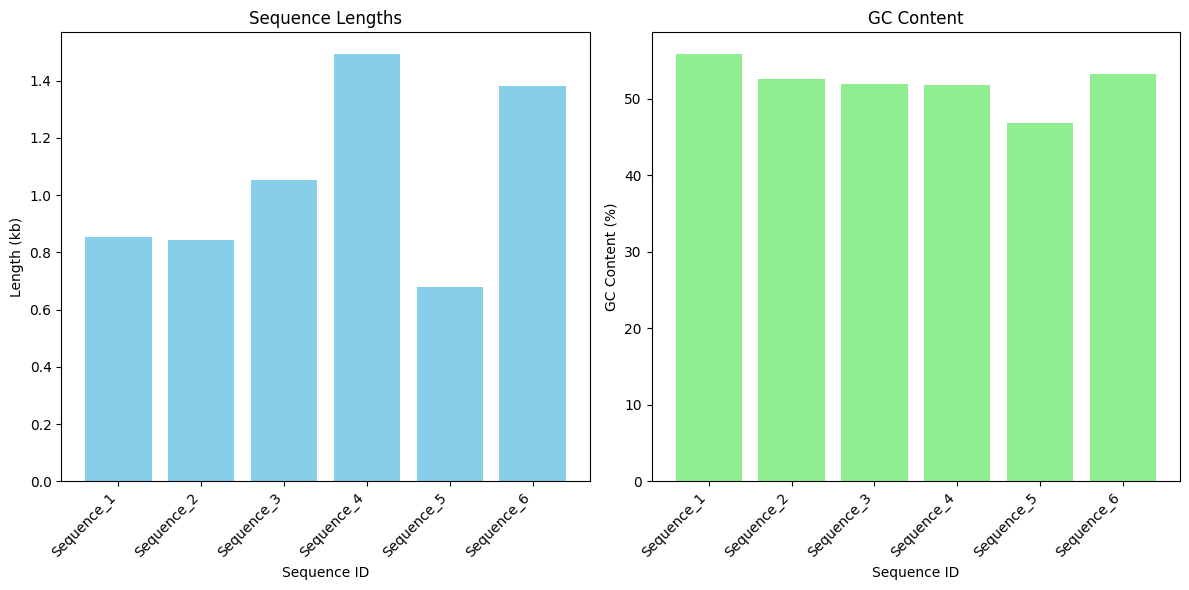

In [ ]:
def gc_content(seq):
    seq = seq.lower()
    gc_count = seq.count('g') + seq.count('c')
    return (gc_count / len(seq)) * 100 if len(seq) > 0 else 0

def analyze_sequences(fasta_file):
    sequence_lengths = []
    gc_contents = []
    sequence_ids = []

    for record in SeqIO.parse(fasta_file, "fasta"):
        sequence_lengths.append(len(record.seq) / 1000)
        gc_contents.append(gc_content(str(record.seq)))
        sequence_ids.append(record.id)


    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.bar(sequence_ids, sequence_lengths, color='skyblue')
    plt.xlabel("Sequence ID")
    plt.ylabel("Length (kb)")
    plt.title("Sequence Lengths")
    plt.xticks(rotation=45, ha="right")

    plt.subplot(1, 2, 2)
    plt.bar(sequence_ids, gc_contents, color='lightgreen')
    plt.xlabel("Sequence ID")
    plt.ylabel("GC Content (%)")
    plt.title("GC Content")
    plt.xticks(rotation=45, ha="right")

    plt.tight_layout()
    plt.show()

analyze_sequences(nucleotide_sequence_path)


## Translate the sequences

In [ ]:
def translate_sequences(input_fasta, output_faa):
    translated_records = []

    for record in SeqIO.parse(input_fasta, "fasta"):
        # Translate only in frame 1 (starting at position 0)
        dna = record.seq[0:]  # or just record.seq
        protein = dna.translate()

        trans_record = SeqRecord(
            protein,
            id=f"{record.id}_frame1",
            description=f"Translation of {record.id} in reading frame 1"
        )
        translated_records.append(trans_record)

    SeqIO.write(translated_records, output_faa, "fasta")
    print(f"Translated sequences saved to {output_faa}")

translate_sequences(nucleotide_sequence_path, amino_acid_sequence_path)

Translated sequences saved to /content/results/sequences_translated.faa


## Alignment of nucleotide sequences and protein sequences.

In [ ]:
from Bio.Align.Applications import MafftCommandline


# Define input and output files
nucleotide_input = nucleotide_sequence_path
protein_input = amino_acid_sequence_path
nucleotide_output_aln = nucleotide_alignment_path
protein_output_aln = protein_alignment_path

# Check if input files exist
for infile in (nucleotide_input, protein_input):
    if not os.path.exists(infile):
        raise FileNotFoundError(f"Input file '{infile}' not found. Please upload it.")

# Nucleotide alignment with MAFFT
mafft_nucleotide = MafftCommandline(cmd="mafft", input=nucleotide_input)

print("Running MAFFT for nucleotide alignment...")
try:
    stdout, stderr = mafft_nucleotide()
    with open(nucleotide_output_aln, "w") as f:
        f.write(stdout)
except Exception as e:
    raise RuntimeError(f"MAFFT nucleotide alignment failed: {str(e)}")

if not os.path.exists(nucleotide_output_aln):
    raise FileNotFoundError(f"Failed to generate '{nucleotide_output_aln}'.")

# Protein alignment with MAFFT
mafft_protein = MafftCommandline(cmd="mafft", input=protein_input)

print("Running MAFFT for protein alignment...")
try:
    stdout, stderr = mafft_protein()
    with open(protein_output_aln, "w") as f:
        f.write(stdout)
except Exception as e:
    raise RuntimeError(f"MAFFT protein alignment failed: {str(e)}")

if not os.path.exists(protein_output_aln):
    raise FileNotFoundError(f"Failed to generate '{protein_output_aln}'.")

# Convert FASTA to Clustal format
for aln_file in (nucleotide_output_aln, protein_output_aln):
    alignment = AlignIO.read(aln_file, "fasta")
    with open(aln_file, "w") as f:
        AlignIO.write(alignment, f, "clustal")

# Read and display alignments
print("\nNucleotide Alignment:")
nucleotide_alignment = AlignIO.read(nucleotide_output_aln, "clustal")
print(nucleotide_alignment)

print("\nProtein Alignment:")
protein_alignment = AlignIO.read(protein_output_aln, "clustal")
print(protein_alignment)

# Distance matrix calculation
def calculate_distance_matrix(alignment):
    num_seqs = len(alignment)
    dist_matrix = np.zeros((num_seqs, num_seqs))
    for i in range(num_seqs):
        for j in range(i + 1, num_seqs):
            mismatches = sum(1 for a, b in zip(alignment[i], alignment[j]) if a != b)
            dist_matrix[i, j] = mismatches / len(alignment[i])
            dist_matrix[j, i] = dist_matrix[i, j]
    return dist_matrix

# Calculate distance matrices
nucleotide_distances = calculate_distance_matrix(nucleotide_alignment)
protein_distances = calculate_distance_matrix(protein_alignment)

print("\nNucleotide Distance Matrix:")
print(nucleotide_distances)

print("\nProtein Distance Matrix:")
print(protein_distances)

# Similarity calculation with CSV export
def calculate_similarity(dist_matrix, alignment, output_csv):
    similarity_matrix = 1 - dist_matrix
    np.fill_diagonal(similarity_matrix, np.nan)

    # Create DataFrame with sequence IDs as index and columns
    seq_ids = [seq.id for seq in alignment]
    sim_df = pd.DataFrame(similarity_matrix, index=seq_ids, columns=seq_ids)

    # Save to CSV
    sim_df.to_csv(output_csv)
    print(f"Similarity matrix saved to {output_csv}")

    return np.nanmean(similarity_matrix)

# Calculate similarities and save to CSV
nucleotide_similarity = calculate_similarity(nucleotide_distances, nucleotide_alignment, similarities_nucleotide_csv)
protein_similarity = calculate_similarity(protein_distances, protein_alignment, similarities_protein_csv)

print(f"\nAverage Nucleotide Similarity: {nucleotide_similarity:.2%}")
print(f"Average Protein Similarity: {protein_similarity:.2%}")

Running MAFFT for nucleotide alignment...
Running MAFFT for protein alignment...

Nucleotide Alignment:
Alignment with 6 rows and 1825 columns
----------------atggcgaac-------------------...--- Sequence_1
----------------atggcg----------------------...--- Sequence_2
atgaccgtgaaag-cgatggcgctg---------------aaca...--- Sequence_3
atgagcaaaa----ttgcggtgatttatgcgcgctatagcagcg...ttt Sequence_4
atgtgcgtg------tatggctatt-------gccgcattagca...--- Sequence_5
atgagccgcaccctgagcggcgatc------------atcagta...--- Sequence_6

Protein Alignment:
Alignment with 6 rows and 627 columns
-----MANTINLVTKFAPYVDEQFTS------------ESKLS-...--- Sequence_1_frame1
-----MA--IDLVAKFLPYVDEMFTT------------ESKKS-...--- Sequence_2_frame1
MTVKAMALNTNQLFAYLN-----------RGDIA----EFKFS-...--- Sequence_3_frame1
-----MS---KIAVIYARYSSDKQTEDSIEAQVRACR-EYAAAH...ATF Sequence_4_frame1
----------MCVYGYCRISTKQQSI---ERQIRNIKAEYDKA-...--- Sequence_5_frame1
-----MS---RTLSGDHQYYLDKYAK---MAKAAALE-EQRAA-...--- Sequence_6_frame1

Nucleotide D

## Generate phylogenetic trees for the aligned sequences.


Nucleotide Alignment Path:
/content/results/alignments/nucleotide_alignments.aln

Protein Alignment Path:
/content/results/alignments/protein_alignments.aln

Nucleotide Distance Matrix:
Sequence_1  0.000000
Sequence_2  0.096438    0.000000
Sequence_3  0.532055    0.533151    0.000000
Sequence_4  0.663014    0.659726    0.700274    0.000000
Sequence_5  0.393973    0.395068    0.536986    0.598904    0.000000
Sequence_6  0.657534    0.658082    0.655342    0.619178    0.611507    0.000000
    Sequence_1  Sequence_2  Sequence_3  Sequence_4  Sequence_5  Sequence_6

Protein Distance Matrix:
Sequence_1_frame1   0.000000
Sequence_2_frame1   0.141946    0.000000
Sequence_3_frame1   0.609250    0.618820    0.000000
Sequence_4_frame1   0.779904    0.778309    0.834131    0.000000
Sequence_5_frame1   0.545455    0.540670    0.639553    0.706539    0.000000
Sequence_6_frame1   0.762360    0.749601    0.748006    0.752791    0.732057    0.000000
    Sequence_1_frame1   Sequence_2_frame1   Sequence

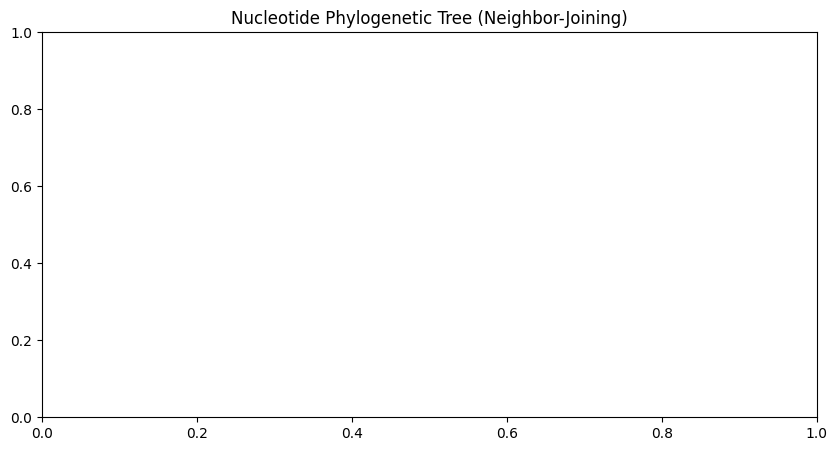

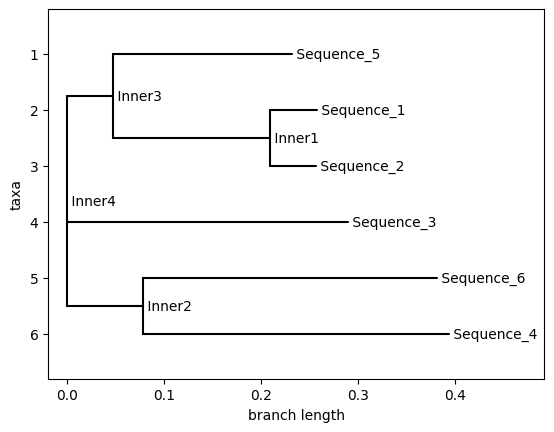

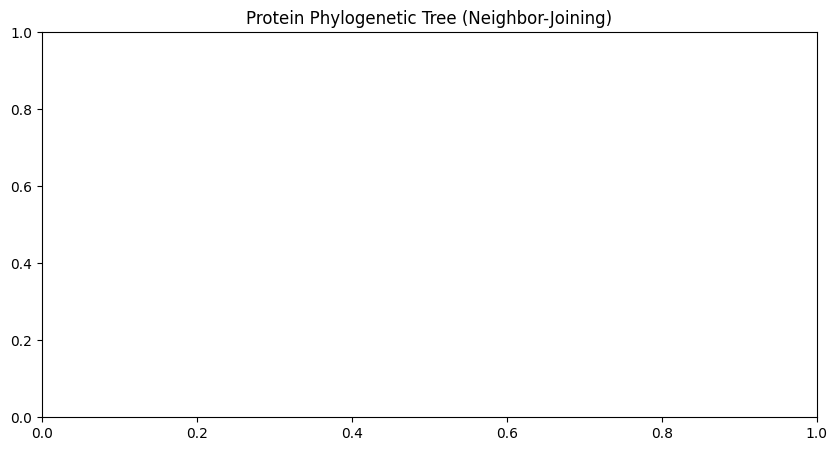

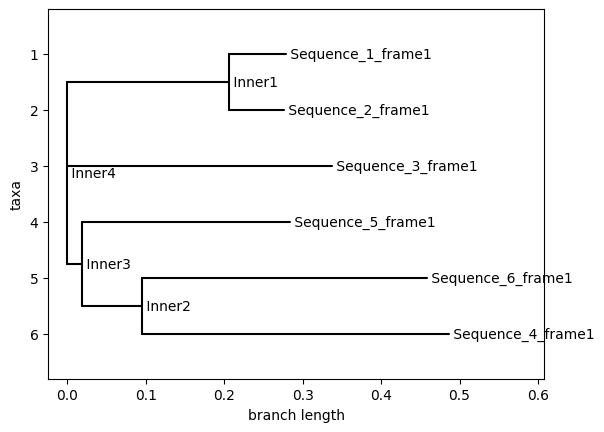

In [ ]:
# Import libraries
from Bio.Align.Applications import MafftCommandline
from Bio import AlignIO
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio import Phylo
import numpy as np
import os
import matplotlib.pyplot as plt



if not os.path.exists(nucleotide_alignment_path):
    print(f"Error: {nucleotide_alignment_path} does not exist.")
if not os.path.exists(protein_alignment_path):
    print(f"Error: {protein_alignment_path} does not exist.")

# Load alignments
print("\nNucleotide Alignment Path:")
print(nucleotide_alignment_path)
nucleotide_alignment = AlignIO.read(nucleotide_alignment_path, "clustal")

print("\nProtein Alignment Path:")
print(protein_alignment_path)
protein_alignment = AlignIO.read(protein_alignment_path, "clustal")

# Distance matrix calculation
calculator = DistanceCalculator('identity')  # Simple mismatch-based distances

# Nucleotide distance matrix and tree
nucleotide_dm = calculator.get_distance(nucleotide_alignment)
print("\nNucleotide Distance Matrix:")
print(nucleotide_dm)

constructor = DistanceTreeConstructor()
nucleotide_tree = constructor.nj(nucleotide_dm)  # Neighbor-Joining tree

# Protein distance matrix and tree
protein_dm = calculator.get_distance(protein_alignment)
print("\nProtein Distance Matrix:")
print(protein_dm)

protein_tree = constructor.nj(protein_dm)  # Neighbor-Joining tree

# Custom similarity calculation
def calculate_similarity(dist_matrix):
    similarity_matrix = 1 - np.array(dist_matrix)  # Convert DistanceMatrix to numpy array
    np.fill_diagonal(similarity_matrix, np.nan)
    return np.nanmean(similarity_matrix)

nucleotide_similarity = calculate_similarity(nucleotide_dm)
protein_similarity = calculate_similarity(protein_dm)

print(f"\nAverage Nucleotide Similarity: {nucleotide_similarity:.2%}")
print(f"Average Protein Similarity: {protein_similarity:.2%}")

# Visualize phylogenetic trees
print("\nVisualizing Phylogenetic Trees...")

# Nucleotide tree
plt.figure(figsize=(10, 5))
plt.title("Nucleotide Phylogenetic Tree (Neighbor-Joining)")
Phylo.draw(nucleotide_tree, do_show=False)
plt.savefig(nucleotide_tree_image)
plt.close()  # Close the figure to avoid display issues in non-interactive environments

# Protein tree
plt.figure(figsize=(10, 5))
plt.title("Protein Phylogenetic Tree (Neighbor-Joining)")
Phylo.draw(protein_tree, do_show=False)
plt.savefig(protein_tree_image)
plt.close()

# Save trees to files
Phylo.write(nucleotide_tree, nucleotide_tree_path, "newick")
Phylo.write(protein_tree, protein_tree_path, "newick")

print(f"Nucleotide tree saved to {nucleotide_tree_path}")
print(f"Protein tree saved to {protein_tree_path}")


## Making predictions using BLAST Search and Hidden Markov Models

In [ ]:
def run_blast_search(seq_record, program="blastx", database="nr", max_hits=5):
    """
    Perform BLAST search and save results with full paths.
    """
    sid = seq_record.id
    blast_xml_path = os.path.join(organism_origin_dir, f"{sid}_blast.xml")
    blast_details_path = os.path.join(blast_details_dir.replace("sequence_ID", sid), f"{sid}_blast_details.txt")

    # Ensure per-sequence directory exists
    os.makedirs(os.path.dirname(blast_details_path), exist_ok=True)

    print(f"Running BLAST for {sid}...")
    try:
        result_handle = NCBIWWW.qblast(program, database, seq_record.seq, hitlist_size=max_hits)
        with open(blast_xml_path, "w") as out_handle:
            out_handle.write(result_handle.read())
        result_handle.close()
    except Exception as e:
        print(f"BLAST failed for {sid}: {e}")
        return [], []

    functions, organisms = [], []
    try:
        with open(blast_xml_path, "r") as blast_handle:
            blast_record = NCBIXML.read(blast_handle)
            with open(blast_details_path, "w") as details_file:
                details_file.write(f"BLAST Results for {sid}\n\n")
                for alignment in blast_record.alignments[:max_hits]:
                    hit_def = alignment.hit_def
                    e_value = alignment.hsps[0].expect
                    functions.append(f"{hit_def} (E={e_value:.2e})")
                    org_match = re.search(r'\[(.*?)\]', hit_def)
                    organisms.append(org_match.group(1) if org_match else "Unknown")
                    details_file.write(f"Hit: {hit_def}\nE-value: {e_value:.2e}\nOrganism: {organisms[-1]}\n\n")
        print(f"BLAST results saved: {blast_xml_path}")
        print(f"BLAST details saved: {blast_details_path}")
    except Exception as e:
        print(f"Error parsing BLAST for {sid}: {e}")
        return ["No hit"], ["Unknown"]

    return functions, organisms

def run_hmmer_search(protein_seq_record, database="pfam", e_value_threshold=1e-5):
    """
    Perform HMMER search and save results with full paths.
    """
    sid = protein_seq_record.id
    hmmer_xml_path = os.path.join(functional_prediction_path, f"{sid}_hmmer.xml")
    hmmer_details_path = os.path.join(hmmer_details_dir.replace("sequence_ID", sid), f"{sid}_hmmer_details.txt")

    # Ensure per-sequence directory exists
    os.makedirs(os.path.dirname(hmmer_details_path), exist_ok=True)

    url = "https://www.ebi.ac.uk/Tools/hmmer/search/hmmscan"
    payload = {"hmmdb": database, "seq": str(protein_seq_record.seq), "domE": str(e_value_threshold)}
    headers = {"Expect": "", "Accept": "text/xml"}

    print(f"Running HMMER for {sid}...")
    try:
        response = requests.post(url, data=payload, headers=headers)
        response.raise_for_status()
        with open(hmmer_xml_path, "w") as f:
            f.write(response.text)
    except Exception as e:
        print(f"HMMER failed for {sid}: {e}")
        return ["No domains detected"]

    domains = []
    try:
        parser = etree.XMLParser(recover=True)
        root = etree.fromstring(response.content, parser=parser)
        results = root.find(".//data[@name='results']")
        if results is not None:
            with open(hmmer_details_path, "w") as details_file:
                details_file.write(f"HMMER Results for {sid}\n\n")
                for hit in results.findall("hits"):
                    for domain in hit.findall("domains"):
                        dom_name = domain.get("alihmmname", "Unknown")
                        e_val = float(domain.get("ievalue", domain.get("evalue", "1")))
                        if e_val <= e_value_threshold:
                            domains.append(f"{dom_name} (E={e_val:.2e})")
                            details_file.write(f"Domain: {dom_name}\nE-value: {e_val:.2e}\n\n")
        print(f"HMMER results saved: {hmmer_xml_path}")
        print(f"HMMER details saved: {hmmer_details_path}")
    except Exception as e:
        print(f"Error parsing HMMER XML for {sid}: {e}")

    return domains if domains else ["No domains detected"]

def predict_functions_and_organisms():
    """
    Run BLAST and HMMER searches and save results as CSVs with full paths.
    """
    nucleotide_records = list(SeqIO.parse(nucleotide_sequence_path, "fasta"))
    protein_records = list(SeqIO.parse(amino_acid_sequence_path, "fasta"))

    if len(nucleotide_records) != len(protein_records):
        raise ValueError("Mismatch between nucleotide and protein sequence counts")

    blast_results = []
    hmmer_results = []

    for nuc_rec, prot_rec in zip(nucleotide_records, protein_records):
        sid = nuc_rec.id
        if sid != prot_rec.id.split("_frame1")[0]:
            print(f"Warning: ID mismatch for {sid}, skipping...")
            continue

        # BLAST search
        blast_funcs, blast_orgs = run_blast_search(nuc_rec)
        blast_results.append({
            "Sequence_ID": sid,
            "Predicted_Functions": "; ".join(blast_funcs),
            "Predicted_Organisms": "; ".join(blast_orgs)
        })

        # HMMER search
        hmmer_domains = run_hmmer_search(prot_rec)
        hmmer_results.append({
            "Sequence_ID": sid,
            "Domain_Predictions": "; ".join(hmmer_domains)
        })

    # Save CSVs
    blast_df = pd.DataFrame(blast_results)
    blast_df.to_csv(organism_prediction_csv, index=False)
    print(f"Organism predictions saved: {organism_prediction_csv}")

    hmmer_df = pd.DataFrame(hmmer_results)
    hmmer_df.to_csv(domain_prediction_csv, index=False)
    print(f"Domain predictions saved: {domain_prediction_csv}")

# Execute the pipeline
try:
    predict_functions_and_organisms()
except Exception as e:
    print(f"Pipeline failed: {e}")

Running BLAST for Sequence_1...
BLAST results saved: /content/results/organism_origin/Sequence_1_blast.xml
BLAST details saved: /content/results/organism_origin/Sequence_1/Sequence_1_blast_details.txt
Running HMMER for Sequence_1_frame1...
HMMER results saved: /content/results/functional_prediction/Sequence_1_frame1_hmmer.xml
HMMER details saved: /content/results/functional_prediction/Sequence_1_frame1/Sequence_1_frame1_hmmer_details.txt
Running BLAST for Sequence_2...
BLAST results saved: /content/results/organism_origin/Sequence_2_blast.xml
BLAST details saved: /content/results/organism_origin/Sequence_2/Sequence_2_blast_details.txt
Running HMMER for Sequence_2_frame1...
HMMER results saved: /content/results/functional_prediction/Sequence_2_frame1_hmmer.xml
HMMER details saved: /content/results/functional_prediction/Sequence_2_frame1/Sequence_2_frame1_hmmer_details.txt
Running BLAST for Sequence_3...
BLAST results saved: /content/results/organism_origin/Sequence_3_blast.xml
BLAST det